# Projet #1 - Régression

# Objectif: modéliser le niveau d’ozone par régression (Upland Maximum Ozone)

In [211]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## 0- Chargement des bibliothèques

In [212]:
# Manipulation de données
import numpy as np
import pandas as pd

# Visualisation de données
import matplotlib.pyplot as plt
import seaborn as sns

# Outils divers
from tqdm import tqdm
from collections import defaultdict

# Machine Learning

In [213]:
# Configuration de la visualisation
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

## I- Lecture du jeu de données

In [216]:
donnees = pd.read_csv('../../data/ozone.csv')
stats = donnees.describe()
dimensions = donnees.shape

In [217]:
print(donnees.head(10))

   ozone    vh  wind  humidity  temp   ibh  dpg  ibt  vis  doy
0      3  5710     4        28    40  2693  -25   87  250    3
1      5  5700     3        37    45   590  -24  128  100    4
2      5  5760     3        51    54  1450   25  139   60    5
3      6  5720     4        69    35  1568   15  121   60    6
4      4  5790     6        19    45  2631  -33  123  100    7
5      4  5790     3        25    55   554  -28  182  250    8
6      6  5700     3        73    41  2083   23  114  120    9
7      7  5700     3        59    44  2654   -2   91  120   10
8      4  5770     8        27    54  5000  -19   92  120   11
9      6  5720     3        44    51   111    9  173  150   12


In [219]:
print(stats)

            ozone           vh        wind    humidity        temp  \
count  330.000000   330.000000  330.000000  330.000000  330.000000   
mean    11.775758  5750.484848    4.890909   58.130303   61.754545   
std      8.011277   105.708241    2.293159   19.865000   14.458737   
min      1.000000  5320.000000    0.000000   19.000000   25.000000   
25%      5.000000  5690.000000    3.000000   47.000000   51.000000   
50%     10.000000  5760.000000    5.000000   64.000000   62.000000   
75%     17.000000  5830.000000    6.000000   73.000000   72.000000   
max     38.000000  5950.000000   21.000000   93.000000   93.000000   

               ibh         dpg         ibt         vis         doy  
count   330.000000  330.000000  330.000000  330.000000  330.000000  
mean   2572.875758   17.369697  161.160606  124.533333  181.727273  
std    1803.885870   35.717181   76.679424   79.362393  106.060593  
min     111.000000  -69.000000  -25.000000    0.000000    3.000000  
25%     877.500000   -9.

In [220]:
print(dimensions)

(330, 10)


### Visualisation des données

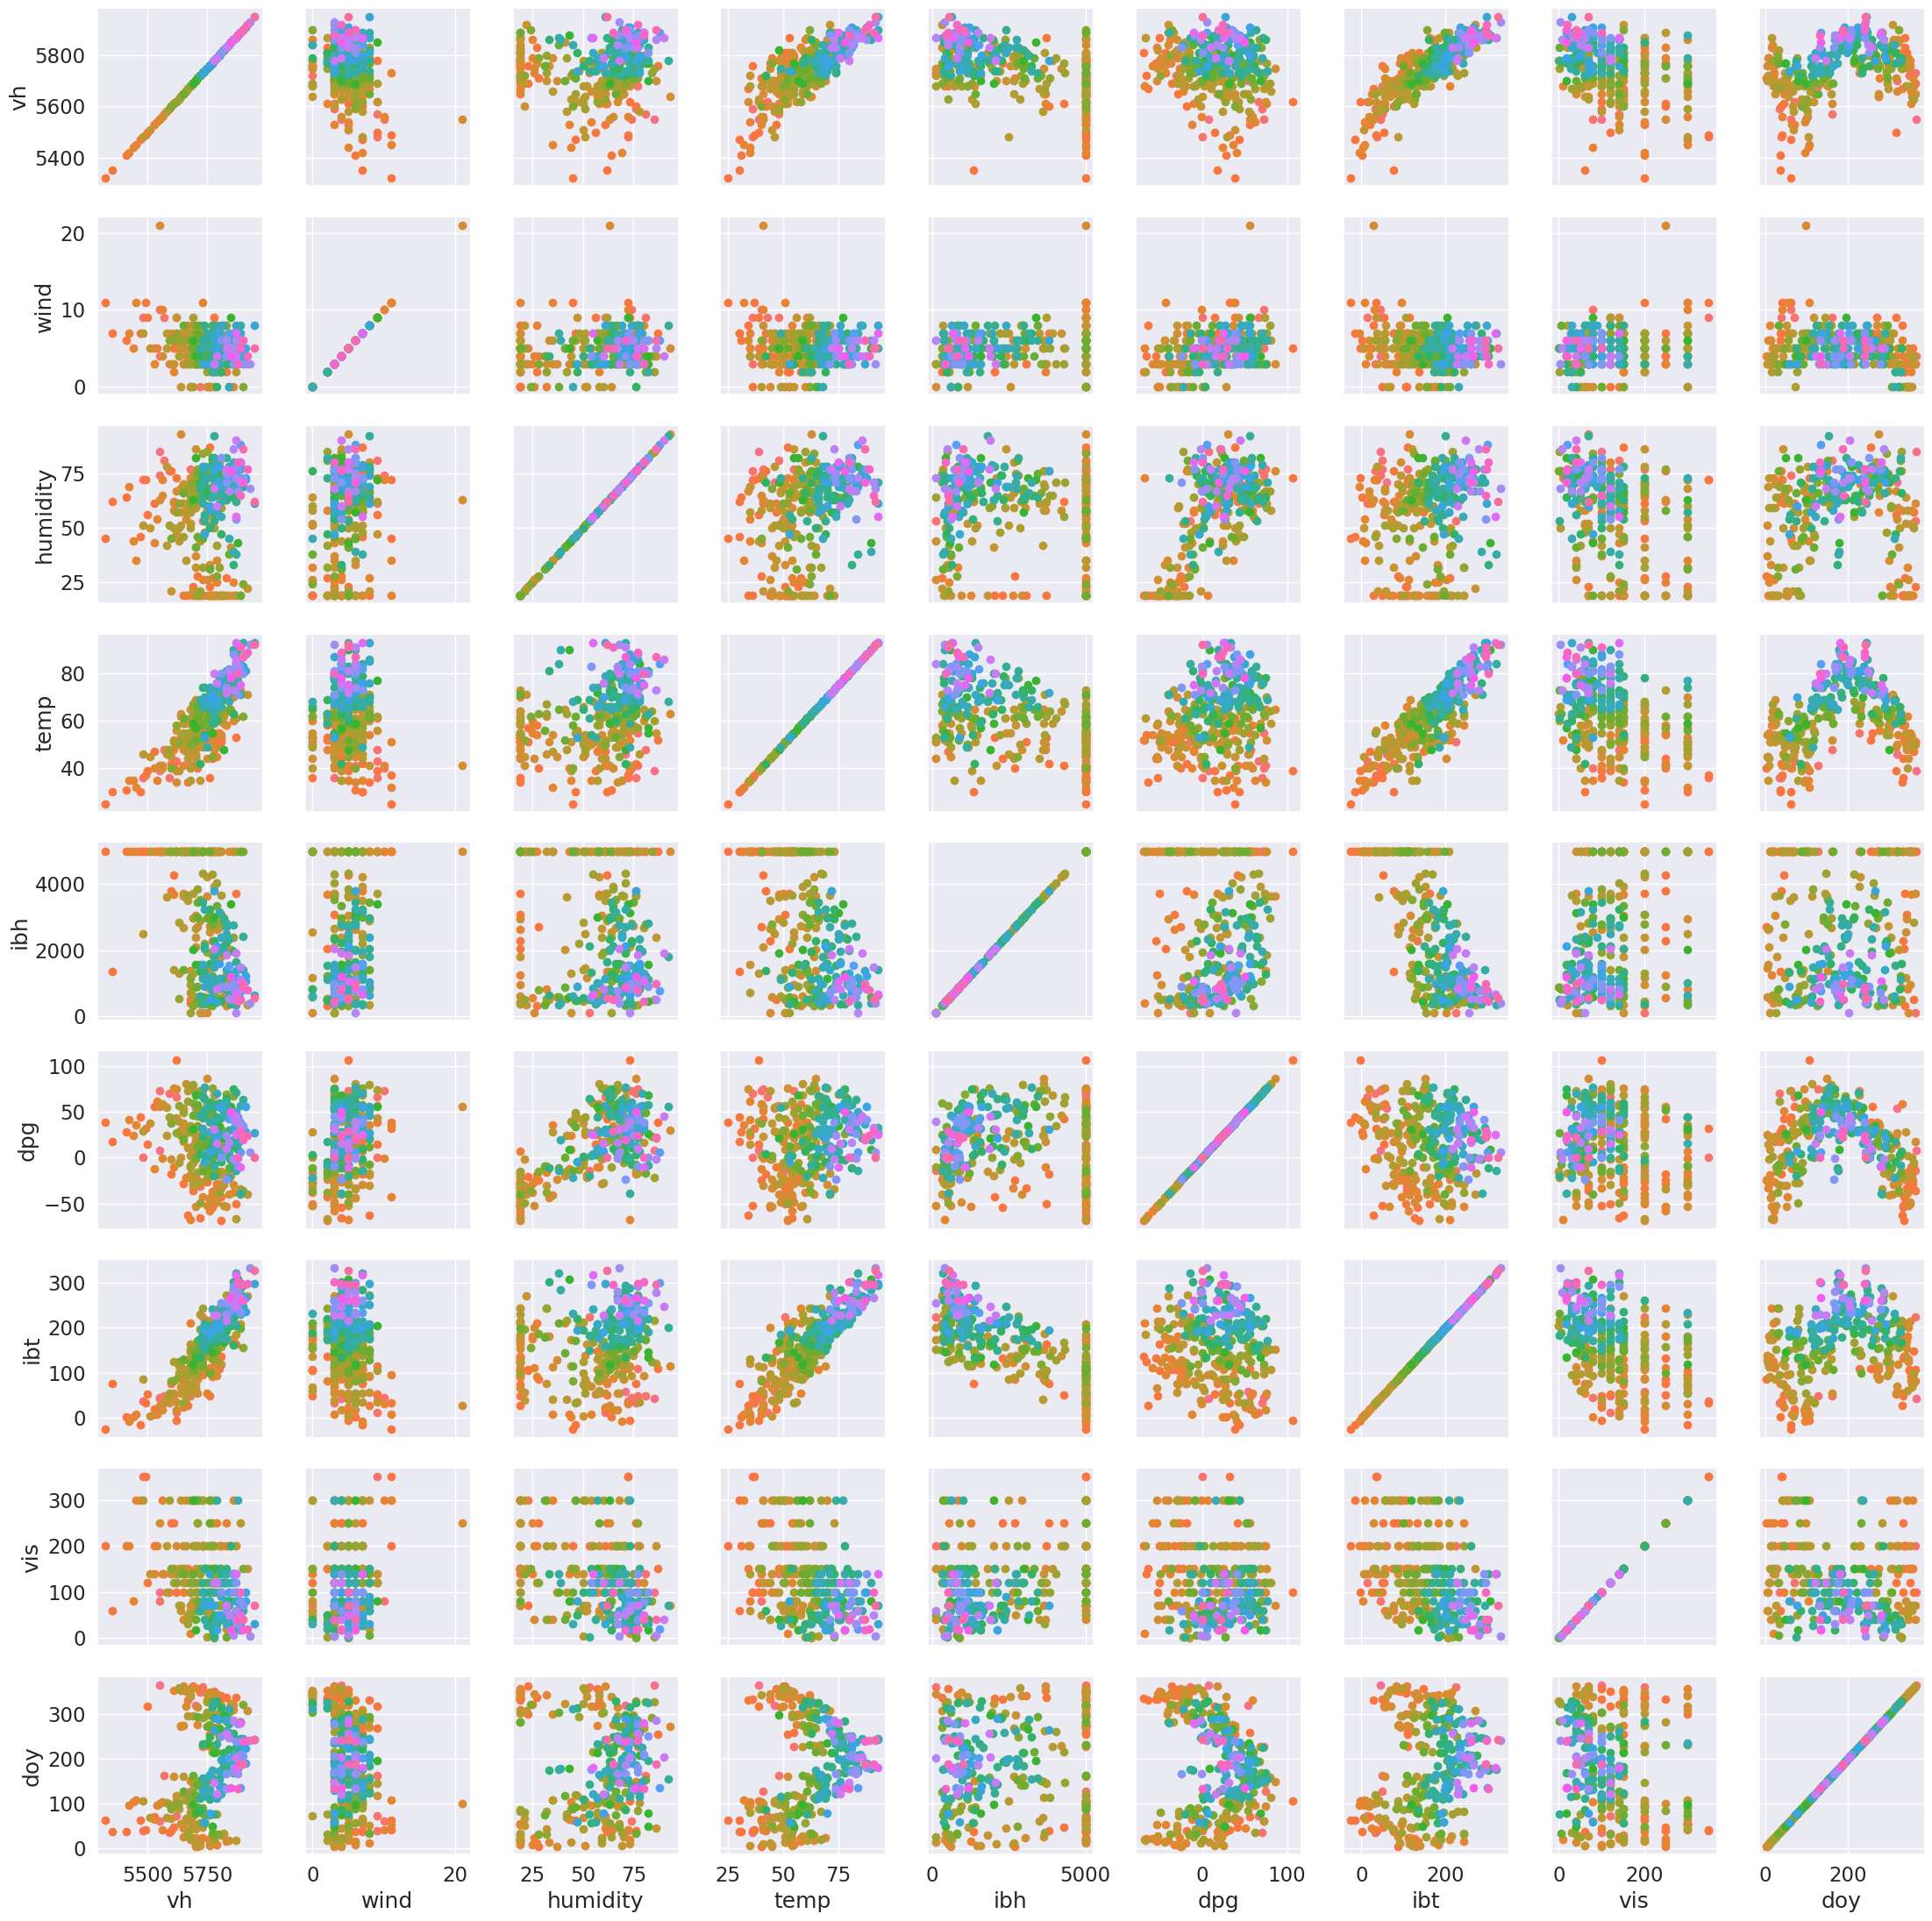

In [221]:
g = sns.PairGrid(donnees, hue='ozone')
g = g.map(plt.scatter)

## II- Préparation des données

In [222]:
# Y'a t-il des données nulles? si oui on les traites adéquatement.

In [223]:
donnees_null = donnees.isnull().sum()

In [224]:
print(donnees_null)

ozone       0
vh          0
wind        0
humidity    0
temp        0
ibh         0
dpg         0
ibt         0
vis         0
doy         0
dtype: int64


In [225]:
# Nous constatons qu'il n'y a pas de données nulles

### Identification des variables dépendantes et de la variable indépendante

In [226]:
X = donnees.drop('ozone', axis = 1)
y = donnees['ozone']

### Standardisation des données 

In [227]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()

In [228]:
X_scaled = scaler.fit_transform(X.values)
y_scaled = scaler.fit_transform(y.values.reshape(-1,1))

### Séparation des données en test et en train

#### Nous allons garder 20% des données pour les tests

In [229]:
from sklearn.model_selection import train_test_split
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.25, 
                                                                                random_state=2021, shuffle=True)

In [230]:
X_train_scaled.shape

(247, 9)

In [231]:
y_train_scaled.shape

(247, 1)

In [232]:
X_test_scaled.shape

(83, 9)

In [233]:
y_test_scaled.shape

(83, 1)

## III- Modèle de régression pour la prédiction du niveau d'ozone

### 1- Modèle de base (dummy) pour la prédiction du niveau d'ozone (moyenne)

In [135]:
from sklearn.dummy import DummyRegressor
dum_reg = DummyRegressor().fit(X_train_scaled, y_train_scaled)

In [239]:
y_pred_train = dum_reg.predict(X_train_scaled)
y_pred_test = dum_reg.predict(X_test_scaled)

In [240]:
from sklearn.metrics import mean_squared_error
RMSE_train_dummy = mean_squared_error(y_train_scaled, y_pred_train, squared=False)
print(f'RMSE train dummmy = {RMSE_train_dummy}')
RMSE_test_dummy = mean_squared_error(y_test_scaled, y_pred_test, squared=False)
print(f'RMSE test dummmy = {RMSE_train_dummy}')

RMSE train dummmy = 1.0169015621392021
RMSE test dummmy = 1.0169015621392021


In [242]:
R2_train_dummy = dum_reg.score(X_train_scaled, y_train_scaled)
R2_test_dummy = dum_reg.score(X_test_scaled, y_test_scaled)
print(f'R2 train dummy = {R2_train_dummy}')
print(f'R2 test dummy = {R2_test_dummy}')

R2 train dummy = 0.0
R2 test dummy = -0.0370058608023478


### 2- Entrainement d'un modèle de régression linéaire multiple (avec toutes les variables d'entrée) avec validation à 5 plis

In [243]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
lreg_model = LinearRegression()

#Tableaux pour stocker les scores sur les différents plis
rmse_train_score = []
rmse_valid_score = []
R2_train_score = []
R2_valid_score = []

kf = KFold(n_splits=5, random_state=None, shuffle=False)
for train_index, valid_index in kf.split(X_train_scaled):
    X_train, X_valid = X_train_scaled[train_index], X_train_scaled[valid_index]
    y_train, y_valid = y_train_scaled[train_index], y_train_scaled[valid_index]
    
    lreg_model.fit(X_train, y_train)
    
    y_pred_train = lreg_model.predict(X_train)
    rmse_train_score.append(mean_squared_error(y_train, y_pred_train, squared=False))
    
    y_pred_valid = lreg_model.predict(X_valid)
    rmse_valid_score.append(mean_squared_error(y_valid, y_pred_valid, squared=False))
    
    R2_train_score.append(lreg_model.score(X_train, y_train))
    R2_valid_score.append(lreg_model.score(X_valid, y_valid))
    
print(rmse_train_score)
print(rmse_valid_score)
print(R2_train_score)
print(R2_valid_score)

[0.5652939849081359, 0.5374502851916141, 0.5288668950250861, 0.5392998722778736, 0.5568012992192465]
[0.48487783895774306, 0.6041935313853732, 0.6402045115408717, 0.5925264030881638, 0.5240897888287128]
[0.6980005839653873, 0.7331920781882162, 0.7002372032191403, 0.7158640779902898, 0.7095561234051253]
[0.7472879453664212, 0.5667396215608171, 0.7018452256041076, 0.6736305071372763, 0.6792754685434607]


#### -Scores moyens sur les données de validation
NB: Ces scores sont déjà meilleurs que ceux du modèle dummy

In [244]:
rmse_moyen_valid = np.mean(rmse_valid_score)
print(f'RMSE moyen validation sur 5 plis = {rmse_moyen_valid}')
R2_moyen_valid = np.mean(R2_valid_score)
print(f'R2 moyen validation sur 5 plis = {R2_moyen_valid}')

RMSE moyen validation sur 5 plis = 0.5691784147601728
R2 moyen validation sur 5 plis = 0.6737557536424166


In [252]:
# On aurait pu utiliser l'approche raccourcie suivante
# from sklearn.model_selection import cross_validate
# scores_rmse = cross_validate(lreg_model, X_train_scaled, y_train_scaled, scoring='neg_root_mean_squared_error', cv=kf, 
#                         return_train_score=True)

# scores_r2 = cross_validate(lreg_model, X_train_scaled, y_train_scaled, scoring='r2', cv=kf, return_train_score=True, 
#                         return_estimator=True)
# print(np.abs(scores_rmse['train_score']))
# print(np.abs(scores_rmse['test_score']))
# print(scores_r2['train_score'])
# print(scores_r2['test_score'])

# rmse_moyen_valid = np.abs(np.mean(scores_rmse['test_score']))
# print(f'RMSE moyen validation sur 5 plis = {rmse_moyen_valid}')
# R2_moyen_valid = np.mean(scores_r2['test_score'])
# print(f'R2 moyen validation sur 5 plis = {R2_moyen_valid}')

[0.56529398 0.53745029 0.5288669  0.53929987 0.5568013 ]
[0.48487784 0.60419353 0.64020451 0.5925264  0.52408979]
[0.69800058 0.73319208 0.7002372  0.71586408 0.70955612]
[0.74728795 0.56673962 0.70184523 0.67363051 0.67927547]
RMSE moyen validation sur 5 plis = 0.5691784147601728
R2 moyen validation sur 5 plis = 0.6737557536424166


### 3- Entrainement d'un modèles de regression knn avec validation 5 plis

#### - Nous allons faire varier le nombre de voisin de 1 à 20 et choisir le nombre de voisin avec le meilleur score

In [256]:
from sklearn.neighbors import KNeighborsRegressor

history_score_rmse = defaultdict(list)

history_score_r2 = defaultdict(list)

max_voisin = 21

for k in range(1,max_voisin):
    knn = KNeighborsRegressor(n_neighbors=k)
    
    scores_rsme_knn = cross_validate(knn, X_train_scaled, y_train_scaled, scoring='neg_root_mean_squared_error', cv=kf, 
                                 return_train_score=True)
    scores_r2_knn = cross_validate(knn, X_train_scaled, y_train_scaled, scoring='r2', cv=kf, 
                                 return_train_score=True)
    history_score_rmse['train'].append(np.abs(np.mean(scores_rsme_knn['train_score'])))
    history_score_rmse['val'].append(np.abs(np.mean(scores_rsme_knn['test_score'])))
    
    history_score_r2['train'].append(np.mean(scores_r2_knn['train_score']))
    history_score_r2['val'].append(np.mean(scores_r2_knn['test_score']))

#### - Choix du meilleur modèle knn en fonction des performances enregistrées par nombre de voisins 

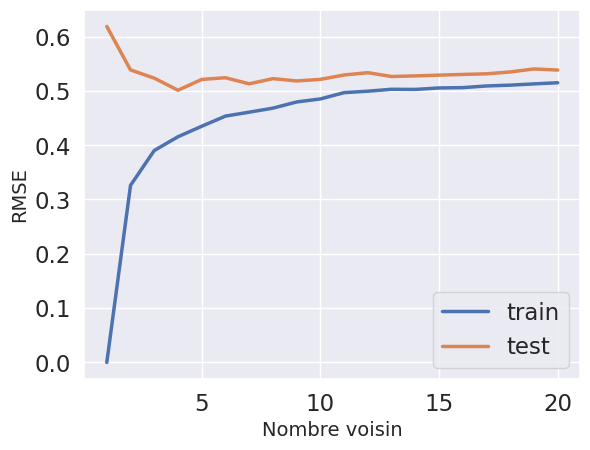

In [257]:
f, ax = plt.subplots(1,1)
ax.plot(range(1, max_voisin), history_score_rmse['train'], label="train")
ax.plot(range(1, max_voisin), history_score_rmse['val'], label="test")
ax.set_xlabel('Nombre voisin', fontsize=14)
ax.set_ylabel('RMSE', fontsize=14)
ax.legend()

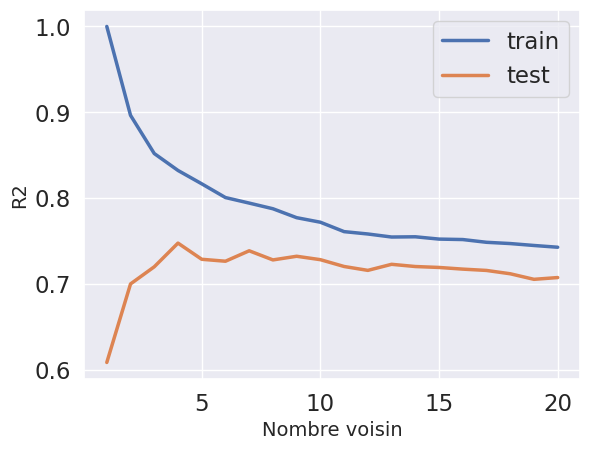

In [258]:
f, ax = plt.subplots(1,1)
ax.plot(range(1, max_voisin), history_score_r2['train'], label="train")
ax.plot(range(1, max_voisin), history_score_r2['val'], label="test")
ax.set_xlabel('Nombre voisin', fontsize=14)
ax.set_ylabel('R2', fontsize=14)
ax.legend()

##### Nous constatons qu'entre 5 et 10 voisins, nous avons le meilleur compromis entre les performances d'entrainement et de validation. Nous allons choisir 5 voisins pour notre modèle knn final

##### - Score du modèle de regression Knn avec 5 voisins

In [260]:
knn_5 = KNeighborsRegressor(n_neighbors=5)
scores_rsme_knn = cross_validate(knn_5, X_train_scaled, y_train_scaled, scoring='neg_root_mean_squared_error', cv=kf, 
                                 return_train_score=True)
scores_r2_knn = cross_validate(knn_5, X_train_scaled, y_train_scaled, scoring='r2', cv=kf, 
                                 return_train_score=True)

scores_rsme_knn_moyen_valid = np.abs(np.mean(scores_rsme_knn['test_score']))
print(f'RMSE knn moyen validation sur 5 plis = {scores_rsme_knn_moyen_valid}')
scores_r2_knn_moyen_valid = np.mean(scores_r2_knn['test_score'])
print(f'R2 knn moyen validation sur 5 plis = {scores_r2_knn_moyen_valid}')

RMSE knn moyen validation sur 5 plis = 0.5210338123622953
R2 knn moyen validation sur 5 plis = 0.7286955516215783


##### Le modèle de regression knn sur k plis avec 5 voisins s'avère être plus performant à predire le niveau d'ozone que le modèle de régression lineaire

### 4- Entraînement du meilleur modèle sur le jeu d’entraînement

In [261]:
knn_5.fit(X_train_scaled, y_train_scaled)

KNeighborsRegressor()

In [265]:
# Scores
y_pred_knn5 = knn_5.predict(X_train_scaled)
RMSE_knn_5 = mean_squared_error(y_train_scaled, y_pred_knn5, squared=False)
R2_knn_5 = knn_5.score(X_train_scaled, y_train_scaled)

print(RMSE_knn_5)
print(R2_knn_5)

0.4277202961062545
0.8230861276258422


##### - Performances du modèle final sur les données de test

### 5- Application des différents type de regularisation

#### 5.1- Régularisation de Tikhonov - Ridge Regression

In [381]:
from sklearn.linear_model import RidgeCV
rcv_model = RidgeCV(alphas=(0.1, 1.0, 10.0, 13.0), fit_intercept=True, scoring=None, cv=None, gcv_mode=None, 
                    store_cv_values=True)

In [382]:
rcv_model.fit(X_train_scaled, y_train_scaled)

RidgeCV(alphas=(0.1, 1.0, 10.0, 13.0), store_cv_values=True)

In [383]:
alpha = rcv_model.alpha_
print(f'alpha = {alpha}')

alpha = 13.0


##### 5.1.1- Score

In [385]:
rcv_model.cv_values_
mean_RMSE_valid = np.sqrt(np.mean(rcv_model.cv_values_))
print(f'mean RMSE validation = {mean_RMSE_valid}')

mean RMSE validation = 0.570237681879532


In [366]:
y_pred_rcv_train = rcv_model.predict(X_train_scaled)
RMSE_rcv_train = mean_squared_error(y_train_scaled, y_pred_rcv_train, squared=False)
print(f'RMSE rcv train = {RMSE_rcv_train}')
R2_rcv_train = rcv_model.score(X_train_scaled, y_train_scaled)
print(f'R2 rcv train = {R2_rcv_train}')

RMSE rcv train = 0.5500256790742505
R2 rcv train = 0.7074446107330726


In [379]:
# y_pred_rcv_test = rcv_model.predict(X_test_scaled)
# RMSE_rcv_test = mean_squared_error(y_test_scaled, y_pred_rcv_test, squared=False)
# print(f'RMSE rcv test = {RMSE_rcv_test}')
# R2_rcv_test = rcv_model.score(X_test_scaled, y_test_scaled)
# print(f'R2 rcv test = {R2_rcv_test}')

#### 5.2- Régulation Lasso

In [348]:
from sklearn.linear_model import LassoCV
lcv_model = LassoCV(eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, precompute='auto', 
                    max_iter=1000, tol=0.0001, copy_X=True, cv=None, verbose=False, n_jobs=None, positive=False, 
                    random_state=None, selection='cyclic')

In [349]:
lcv_model.fit(X_train_scaled, y_train_scaled.ravel())

LassoCV()

In [378]:
alpha = lcv_model.alpha_
print(f'alpha = {alpha}')

alpha = 0.017722263066979948


##### 5.2.1- Score

In [375]:
mean_RMSE_valid = np.sqrt(np.mean(lcv_model.mse_path_))
print(f'mean RMSE validation = {mean_RMSE_valid}')

mean RMSE validation = 0.6249750555506876


In [350]:
y_pred_lcv_train = lcv_model.predict(X_train_scaled)
RMSE_lcv_train = mean_squared_error(y_train_scaled, y_pred_lcv_train, squared=False)
print(f'RMSE lcv train = {RMSE_lcv_train}')
R2_lcv_train = lcv_model.score(X_train_scaled, y_train_scaled)
print(f'R2 lcv train = {R2_lcv_train}')

RMSE lcv train = 0.5497407283273045
R2 lcv train = 0.7077476594298289


#### 5.3- Régulation ElasticNet

In [361]:
from sklearn.linear_model import ElasticNetCV
elcv_model = ElasticNetCV(l1_ratio=0.5, eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, precompute='auto', 
                          max_iter=1000, tol=0.0001, cv=None, copy_X=True, verbose=0, n_jobs=None, positive=False, 
                          random_state=None, selection='cyclic')

In [362]:
elcv_model.fit(X_train_scaled, y_train_scaled.ravel())

ElasticNetCV()

In [374]:
alpha = elcv_model.alpha_
print(f'alpha = {alpha}')

alpha = 0.030827841253271565


##### 5.3.1- Score

In [373]:
mean_RMSE_valid = np.sqrt(np.mean(elcv_model.mse_path_))
print(f'mean RMSE validation = {mean_RMSE_valid}')

mean RMSE validation = 0.6335670501809344


In [367]:
y_pred_elcv_train = elcv_model.predict(X_train_scaled)
RMSE_elcv_train = mean_squared_error(y_train_scaled, y_pred_elcv_train, squared=False)
print(f'RMSE elcv train = {RMSE_elcv_train}')
R2_elcv_train = elcv_model.score(X_train_scaled, y_train_scaled)
print(f'R2 elcv train = {R2_elcv_train}')

RMSE elcv train = 0.5498025645539645
R2 elcv train = 0.7076819091682165


##### Malgré l'application de la régulation, nous n'arrivons pas à égaler le score de la regression knn avec 5 voisins avec validation sur 5 plis. ça va de sois parce que notre jeux de données n'a pas de problème de dimensions (juste 9 variables d'entrée)
